# Concept Drift on MNIST

### EDTS 2018-2019 ASI5
### Ismail EL HACHIMI - Mathieu VANDECASTEELE

~ [Paper](http://proceedings.mlr.press/v32/harel14.pdf)

In [1]:
from cd_utils import *

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_mldata

# Load data
We've decided to work with MNIST which is a famous database to try many different process for Machine Learning.

In [2]:
mnist = fetch_mldata('MNIST original')

In [3]:
# get Stream data
n, = mnist.target.shape
X, _, y, _ = train_test_split(mnist.data, mnist.target, test_size=1/7, 
                              random_state=42, shuffle=True)
del mnist
print("Stream of {} samples.".format(X.shape[0]))

Stream of 60000 samples.


In [4]:
whos | grep ndarray

Variable   Type       Data/Info
-------------------------------
X          ndarray    60000x784: 47040000 elems, type `uint8`, 47040000 bytes (44.86083984375 Mb)
y          ndarray    60000: 60000 elems, type `float64`, 480000 bytes (468.75 kb)


## Concept Drift
Transpose a set of pictures, the expected result is a Concept Drift at k = 1300.

In [5]:
X[1300:1400, :] = X[1300:1400, ::-1] 

In [ ]:
stream_size = 100
Stream = DataStream(X[:3000,:], y[:3000], size=stream_size)

D, times, Rord_list, Rsmean_list = concept_drift_scheme(window_size=stream_size, 
                                                        permut=30, 
                                                        cd_size=0.04, 
                                                        significance_rate=0.5,
                                                        data_stream=Stream)

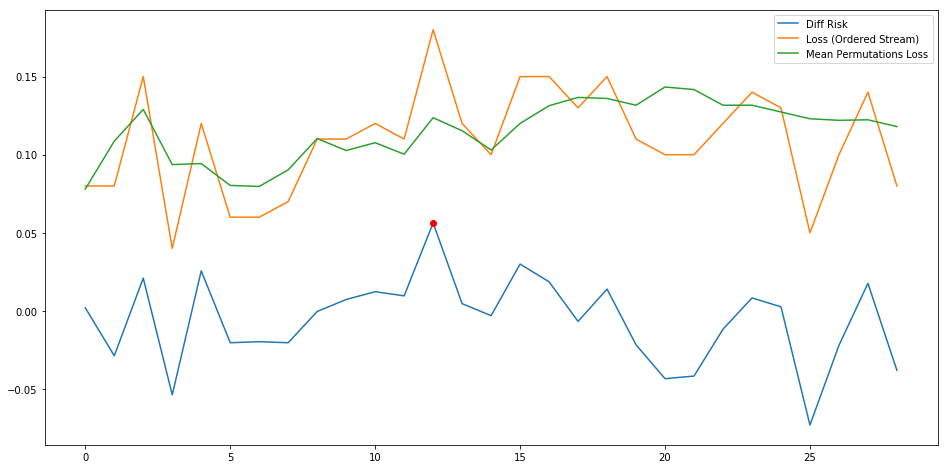

In [10]:
R = []

for i in range(len(Rsmean_list)):
    R.append(Rord_list[i] - Rsmean_list[i])

plt.figure(figsize=(16, 8))
plt.plot(R, label='Diff Risk')
plt.plot(Rord_list, label="Loss (Ordered Stream)")
plt.plot(Rsmean_list, label="Mean Permutations Loss")
for i in list(D.keys()):
    plt.plot(i-1, R[i-1], 'ro')
plt.legend();

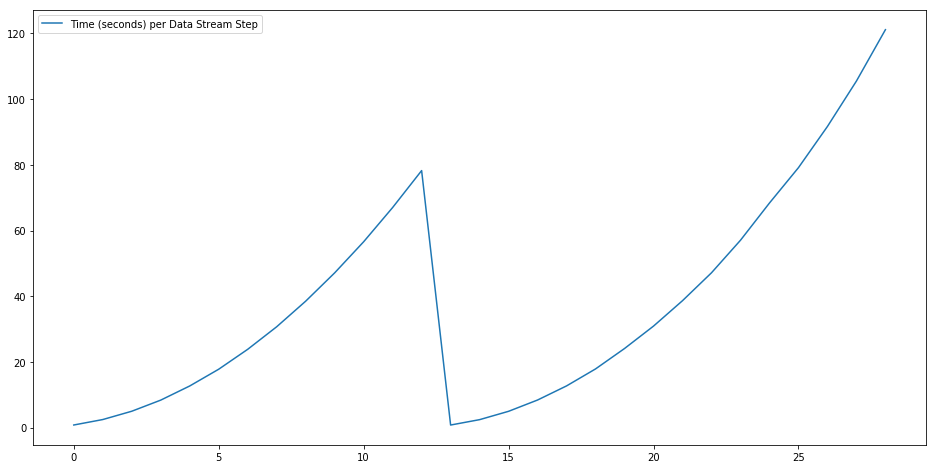

In [11]:
plt.figure(figsize=(16, 8))
plt.plot(times, label='Time (seconds) per Data Stream Step')
plt.legend();

We can observe the concept drift around 13. Our algorithm works well. We need to find now the solution to correct it.